In [42]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk
from nltk.tokenize.casual import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from nltk.collocations import *
pd.set_option('display.max_colwidth', 200)

In [2]:
f = pd.read_csv("./hillary-clinton-emails/Emails.csv", index_col = "Id")
f[:][:1]

,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
Id,,,,,,,,,,,,,,,,,,,,,
1,C05739545,WOW,H,"Sullivan, Jacob J",87,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545/C05739545.pdf,F-2015-04841,HRC_Email_296,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase No. F-2015-04841\nDoc No. C05739545\nDate: 05/13/2015\nSTATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.\nSUBJECT TO AGREEMENT ON SENSITIVE INFORMA...


In [3]:
import random
data = pd.DataFrame()
data = f
data = data.fillna("")
data["rand_row"] = [str(random.randint(10000, 20000)) for i in xrange(len(data))]
data["new_row"] = data["MetadataSubject"] + "\n" + data["rand_row"] + "\n" +\
        data["MetadataFrom"].astype(str) + "\n" + data["rand_row"] + "\n" + data["MetadataTo"]\
        + "\n" + data["rand_row"] + "\n" + data["ExtractedBodyText"]

In [30]:
def get_features(ngram_range, column_name, stop_words = None, verbose = True, vectorizer = CountVectorizer):
    
    vectorizer = vectorizer(ngram_range=ngram_range, stop_words = stop_words, analyzer="word")
    features = vectorizer.fit_transform(data[column_name])
    
    feature_names = np.array(vectorizer.get_feature_names())
    feature_sum = np.array(map(int, np.matrix(csr_matrix.sum(features, axis = 0)).tolist()[0]))
    table = pd.DataFrame()
    table["names"] = feature_names
    table["sum"] = feature_sum
    table["index"] = range(len(feature_names))
    table = table.sort_values(by="sum")[::-1]
    if(verbose):
        print "ngram_range =", ngram_range, "stop_words = ", stop_words
        print "# of features=", len(vectorizer.get_feature_names())
        print "\nMost common %d-grams:"%ngram_range[1] + "\n"
        print table[:5]
    return table, vectorizer, features

In [20]:
table, vectorizer, features = get_features((2,2), column_name="new_row")

ngram_range = (2, 2) stop_words =  None
# of features= 296273

Most common 2-grams:

              names   sum   index
189510       of the  3418  189510
243094    state gov  2617  243094
141325       in the  2567  141325
28601   abedin huma  1618   28601
268788       to the  1495  268788


In [21]:
table, vectorizer, features = get_features((2,2), column_name="new_row", stop_words="english")

ngram_range = (2, 2) stop_words =  english
# of features= 271671

Most common 2-grams:

                 names   sum   index
234771       state gov  2617  234771
29425      abedin huma  1618   29425
165220    mills cheryl  1450  165220
239780  sullivan jacob   923  239780
165270   millscd state   549  165270


In [7]:
column_of_data = "new_row"

In [48]:
tokens = nltk.wordpunct_tokenize(" ".join(data[column_of_data].values))
finder = BigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(5)
finder.apply_word_filter(lambda w: len(w) < 3)
finder.nbest(bigram_measures.pmi, 10)

[('BEN', 'FEDER'),
 ('BHUTTO', 'ASSASSINATION'),
 ('CONSULAR', 'FEES'),
 ('Chico', 'Menashe'),
 ('Deep', 'Throat'),
 ('MARIE', 'SLAUGHTER'),
 ('SUU', 'KYI'),
 ('BAILEY', 'HUTCHISON'),
 ('Belief', 'Blog'),
 ('Buenos', 'Aires')]

In [58]:
from sklearn.cluster.hierarchical import AgglomerativeClustering
from sklearn.cluster import KMeans


table, vectorizer, features = get_features((2,2), column_of_data, stop_words="english", vectorizer=TfidfVectorizer, \
                                           verbose = False)
print "\n", "==========================", "\n"
#model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
num_clusters = 10
model = KMeans(n_clusters=num_clusters, n_jobs=-1)
model.fit(features)
preds = model.predict(features)
print "№_of_cluster, amount"
for i in xrange(num_clusters):
    print i, (preds == i).sum()



№_of_cluster, amount
0 112
1 393
2 1375
3 242
4 78
5 701
6 1000
7 2620
8 1118
9 306


In [35]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Computing PCA projection


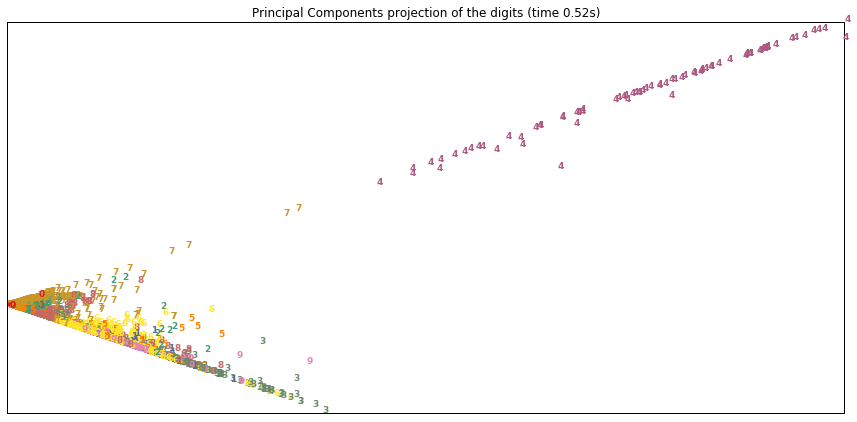

In [59]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

X = features
y = preds
n_samples, n_features = features.shape
n_neighbors = 30
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(15,7))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        color = y[i] * 1.0 / num_clusters
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(color),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

        
        
print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

никакой другой embedding у меня просто не посчитался

In [60]:
distances = pd.DataFrame(model.transform(features))
print "closest e-mail for each cluster"
print "format:Subject FROM TO\nHere we are:"
amount_of_best_to_print = 4
for i in xrange(num_clusters):
    cur_best = distances[distances.columns[i]][preds == i].sort_values(distances.columns[0])
    best_i = cur_best.index[:amount_of_best_to_print]
    print "===========================================================\n cluster #%d"%i
    for j in xrange(min(amount_of_best_to_print, len(cur_best))):
        arr = np.array(data[column_of_data].iloc[best_i[j]].split("\n"))
        if(len(arr) >= 7):
            print "\n", arr[[0,2,4,6]]
        else:
            print "\n", arr
        print "\n==================="

closest e-mail for each cluster
format:Subject FROM TO
Here we are:
 cluster #0

['TRYING TO CALL YOU -- CALL ME THRU OPS.' 'Verma, Richard R' 'H'
 'His cell is:']


['TRYING TO CALL YOU -- CALL ME THRU OPS.' 'Verma, Richard R' 'H'
 'Verma, Richard R <VermaRR@state.gov>']


[ 'WE HAVE INFORMED OUR CLOAKROOM THAT WE LIFT THE HOLD ON SHANNON NOMINATION'
 'Verma, Richard R' 'H' 'Verma, Richard R <VermaRR@state.gov>']


[ 'WE HAVE INFORMED OUR CLOAKROOM THAT WE LIFT THE HOLD ON SHANNON NOMINATION'
 'Verma, Richard R' 'H' 'Verma, Richard R <VermaRR@state.gov>']

 cluster #1

['FOR HRC' 'H' 'abedinh@state.gov' 'H <hrod17@clintonemail.com>']


['RE:' 'H' 'abedinh@state.gov' 'I can do at 2.']


['RE:' 'H' 'abedinh@state.gov' '']


['RE:' 'H' 'abedinh@state.gov' '']

 cluster #2

['' 'Abedin, Huma' 'H' 'Kerry']


['' 'Abedin, Huma' '' 'Cc:']


['RE:' 'Abedin, Huma' 'H' 'Abedin, Huma <AbedinH@state.gov>']


['RE:' 'Abedin, Huma' 'H' 'Abedin, Huma <AbedinH@state.gov>']

 cluster #3

['RE:' 'hrod1

Итог работы: В качестве данных я решил взять четыре поля - subject,from,to,bodyText. Я пробовал разные варианты - сырой текст, только тело письма, разные комбинации, получалось по ощущениям хуже, разбиение по классам было очень неравномерно. В итоге остановился на этом, как на довольно показательной комбинации. AgglomerativeClustering у меня не посчитался, очень долго, оставил KMeans. Число кластеров выбрал так, чтобы каждый был довольно представительным, в остальном более-менее случайно. В качестве иллюстрации вывожу проекцию на полскость с помощью pca, в принципе, видно, что присутствует кластерная структура, так же вывожу несколько самых близких объектов к центрам каждого класса. Как правило, у них совпадают получатели/отправители, но один раз я натыкался на письма по аргентине. Здесь CountVectorizer выраждает классы, работает плохо, оставил TfIdfVectorizer. В принципе, достаточно интерпретируемые результаты, одно жалко - что сгруппировались больше по мета-даным, нежели чем по сути писем.